# 2D multi-task optimisation

This notebook shows how to run multi-task optimisation with one support task. The notebook also shows how to increase the cost limit to continue optimisation when a cost-aware acquisition function is used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from boss.bo.bo_main import BOMain
from utils import load_model

optimisation setup:

In [3]:
seed = 123
num_init = 5
num_iter = 15

optimisation tasks:

In [4]:
def f_0(x):
    return unknown_model_0.predict(np.atleast_2d(x))[0]

def f_1(x):
    return unknown_model_1.predict(np.atleast_2d(x))[0]

In [5]:
unknown_model_0 = load_model('../models/model_2D_E0.npz')
unknown_model_1 = load_model('../models/model_2D_E1.npz')
bounds = [[-50.0, 310.0]] * 2

plot:

In [6]:
xp = np.linspace(-50, 310, 361)
x1, x2 = np.meshgrid(xp, xp) 
levels = 25

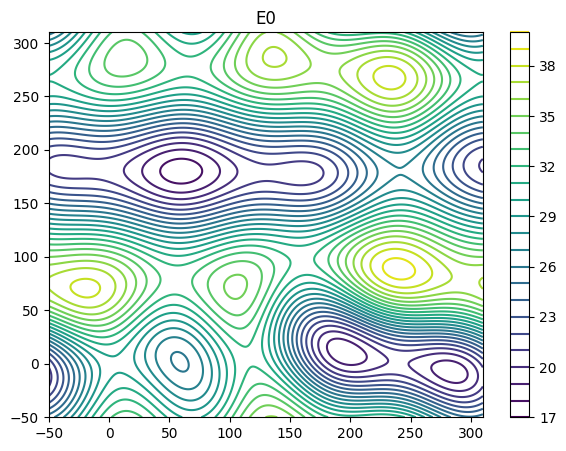

In [7]:
plt.figure(figsize=(7, 5))
yp = f_0(np.column_stack((x1.ravel(), x2.ravel())))
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E0');

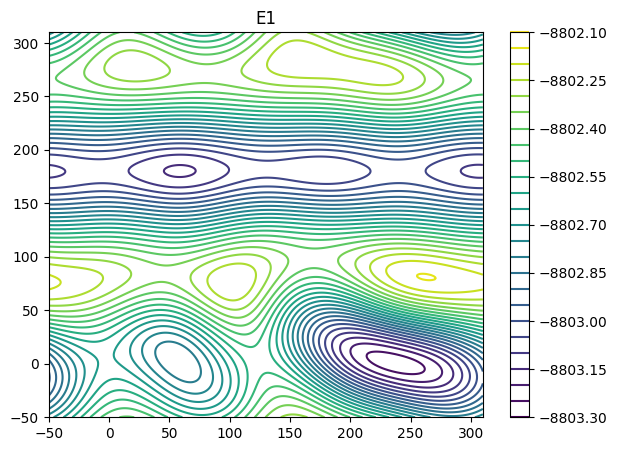

In [8]:
plt.figure(figsize=(7, 5))
yp = f_1(np.column_stack((x1.ravel(), x2.ravel())))
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E1');

## baseline optimisation

In [9]:
bo_1 = BOMain(
    f_1, 
    bounds,
    yrange=[0, 1],
    kernel='stdp',
    initpts=num_init,
    iterpts=num_iter,
    minfreq=num_iter,
    seed=seed,
    outfile='boss_2D_E1.out',
    rstfile='boss_2D_E1.rst',
)

In [10]:
%time res_1 = bo_1.run()

CPU times: user 6.32 s, sys: 1.83 s, total: 8.15 s
Wall time: 6.16 s


observed output range:

In [11]:
res_1.get_est_yrange()

(-8803.274623517365, -8802.248874943942)

best observed value:

In [12]:
res_1.get_best_acq()

(ObsAr([231.19591074,   3.8883188 ]), array([-8803.27462352]))

estimated minimum and predicted minimum value:

In [13]:
[res_1.select('x_glmin', -1), res_1.select('mu_glmin', -1)]

[array([238.07955201,   3.05496467]), -8803.27986390601]

evaluate estimated minimum:

In [14]:
f_1(res_1.select('x_glmin', -1))

array([[-8803.27467153]])

plot:

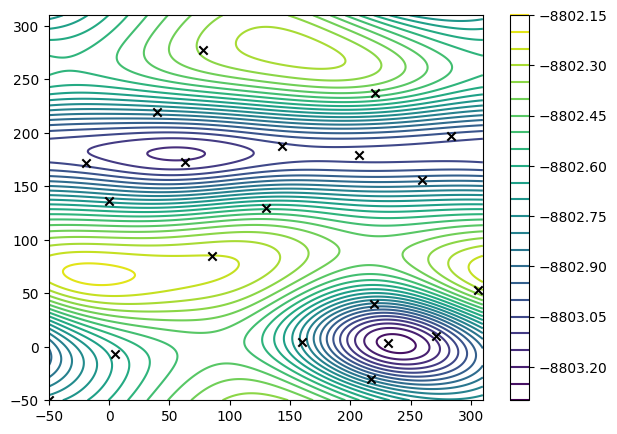

In [15]:
plt.figure(figsize=(7, 5))
yp = bo_1.model.predict(np.column_stack((x1.ravel(), x2.ravel())))[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_1.model.X[:,0], bo_1.model.X[:,1], marker='x', color='k', zorder=10);

## multi-task optimisation

associate acquisitions with a cost:

In [16]:
cost_0 = 0.1
cost_1 = 1

add maximum cost limit to optimisation:

In [17]:
maxcost = (bo_1.settings["initpts"] + bo_1.settings["iterpts"])  * cost_1

In [18]:
bo_2 = BOMain(
    [f_1, f_0], 
    bounds,
    kernel='stdp',
    initpts=num_init,
    iterpts=1000,
    minfreq=1000,
    maxcost=maxcost,
    acqfn_name='elcb_multi',
    task_cost=[cost_1, cost_0],
    seed=seed,
    outfile='boss_multi_2D_E1.out',
    rstfile='boss_multi_2D_E1.rst',
)

optimisation continues until `iterpts` iterations or until `maxcost` is reached

In [19]:
%time res_2 = bo_2.run()

CPU times: user 55.6 s, sys: 12.4 s, total: 1min 7s
Wall time: 48 s


observed output range:

In [20]:
res_2.get_est_yrange()

(array(-8803.27710346), array(-8802.24887494))

see optimisation results:

In [21]:
res_2.get_best_acq()

(ObsAr([237.5105134 ,   0.55784365,   0.        ]), ObsAr([-8803.27710346]))

In [22]:
[res_2.select('x_glmin', -1), res_2.select('mu_glmin', -1)]

[array([237.70758881,   0.77834823,   0.        ]), -8803.277114176053]

evaluate estimated minimum:

In [23]:
f_1(res_2.select('x_glmin', -1)[:-1])

array([[-8803.27710443]])

plot:

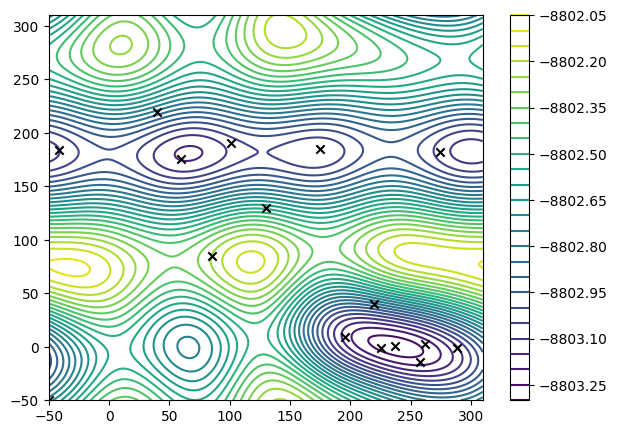

In [24]:
plt.figure(figsize=(7,5))
yp = bo_2.model.predict(np.column_stack((x1.ravel(), x2.ravel())), index=0)[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.get_X(index=0)[:, 0], bo_2.model.get_X(index=0)[:, 1], marker='x', color='k', zorder=10);

support task:

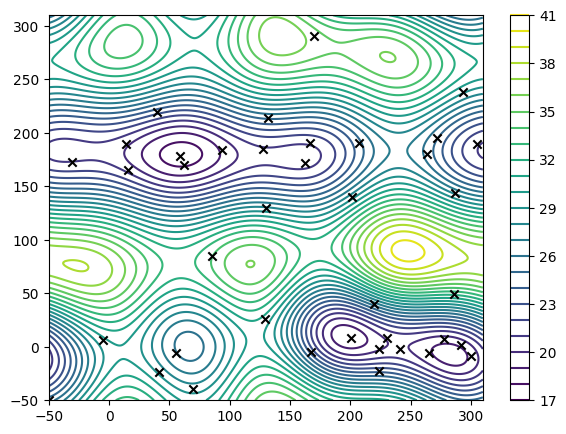

In [25]:
plt.figure(figsize=(7, 5))
yp = bo_2.model.predict(np.column_stack((x1.ravel(), x2.ravel())), index=1)[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.get_X(index=1)[:, 0], bo_2.model.get_X(index=1)[:, 1], marker='x', color='k', zorder=10);

compare acquisition locations:

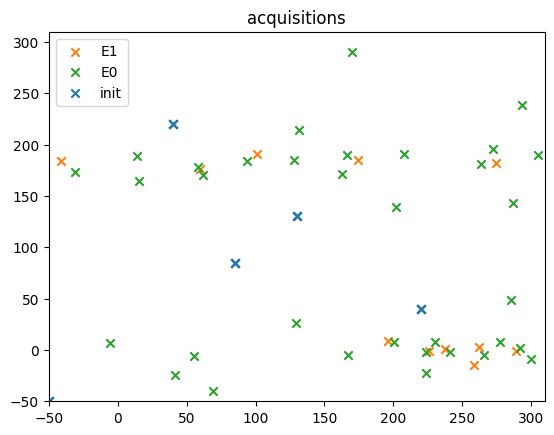

In [26]:
plt.scatter(bo_2.model.get_X(index=0)[:, 0], bo_2.model.get_X(index=0)[:, 1], marker='x', label='E1', color='C1')
plt.scatter(bo_2.model.get_X(index=1)[:, 0], bo_2.model.get_X(index=1)[:, 1], marker='x', label='E0', color='C2')
initpts=res_2.settings["initpts"]
plt.scatter(bo_2.model.X[:initpts, 0], bo_2.model.X[:initpts, 1], marker='x', label='init', color='C0')
plt.xlim(bounds[0])
plt.ylim(bounds[1])
plt.legend()
plt.title('acquisitions');

note: num evaluations with each task

In [27]:
dict(zip(['E1', 'E0'], np.bincount(bo_2.model.inds)))

{'E1': 16, 'E0': 39}

increase cost limit and continue optimisation:

In [28]:
new_maxcost = maxcost + 5 * cost_1

In [29]:
%time res_2 = bo_2.run(maxcost=new_maxcost)

CPU times: user 29.6 s, sys: 6.21 s, total: 35.9 s
Wall time: 26.6 s


In [30]:
dict(zip(['E1', 'E0'], np.bincount(bo_2.model.inds)))

{'E1': 20, 'E0': 48}

see optimisation results:

In [31]:
[res_2.select('x_glmin', -1), res_2.select('mu_glmin', -1)]

[array([237.59950594,   1.07085184,   0.        ]), -8803.277201095629]

In [32]:
f_1(res_2.select('x_glmin', -1)[:-1])

array([[-8803.27705769]])

model reconstruction:

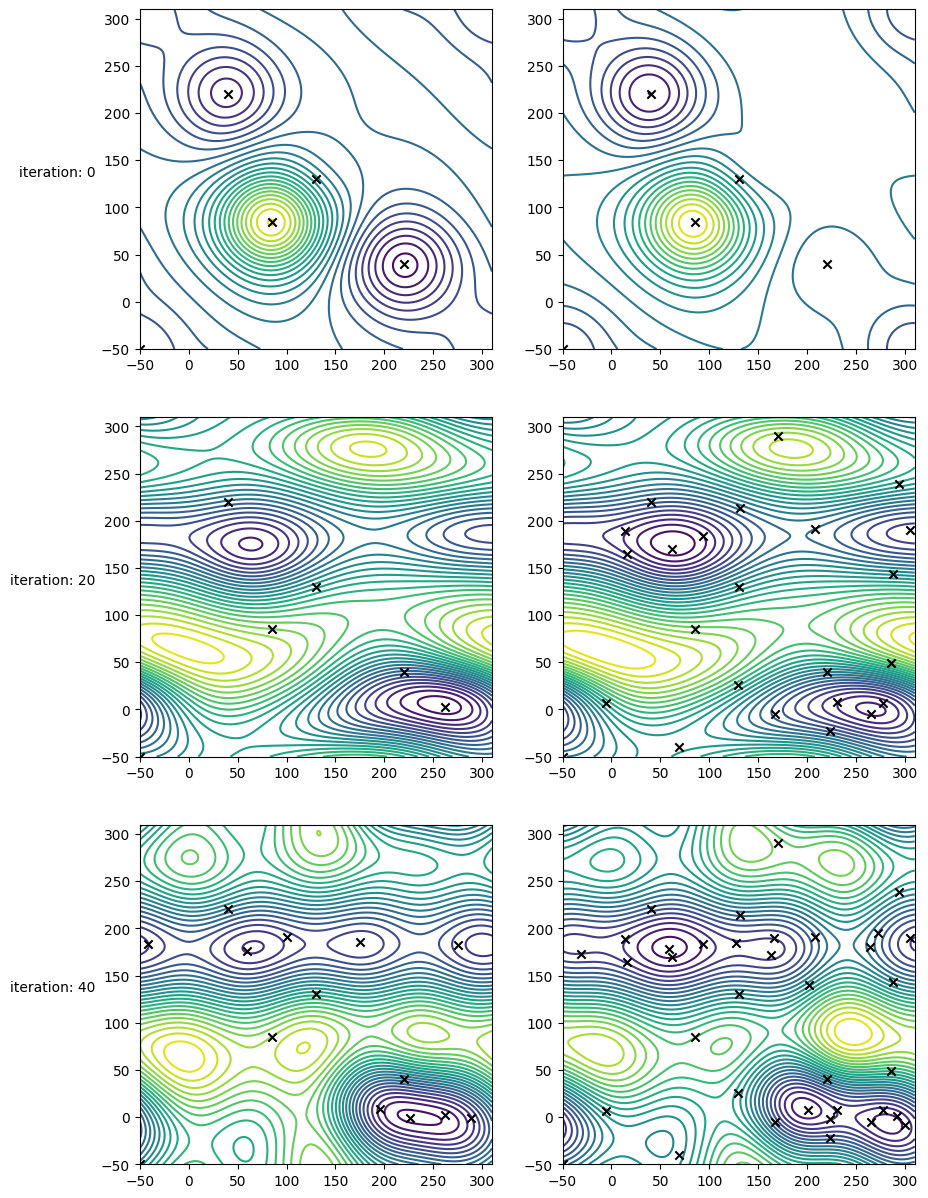

In [33]:
step_size = 20
num_rows = int(np.ceil(res_2.num_iters/step_size))
curr = 0
plt.figure(figsize=(10, num_rows * 5))
for itr in np.arange(res_2.num_iters)[::step_size]:
    curr += 1
    model_itr = res_2.reconstruct_model(itr)
    plt.subplot(num_rows, 2, curr)
    yp = model_itr.predict(np.column_stack((x1.ravel(), x2.ravel())), index=0)[0]
    plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
    plt.ylabel('iteration: {}'.format(itr), rotation='horizontal', ha='right')
    plt.scatter(model_itr.get_X(index=0)[:, 0], model_itr.get_X(index=0)[:, 1], marker='x', color='k', zorder=10);
    curr += 1
    plt.subplot(num_rows, 2, curr)
    yp = model_itr.predict(np.column_stack((x1.ravel(), x2.ravel())), index=1)[0]
    plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
    plt.scatter(model_itr.get_X(index=1)[:, 0], model_itr.get_X(index=1)[:, 1], marker='x', color='k', zorder=10);

## model parameters

add example prior distributions as discussed in init_multi notebooks and rerun optimisation:

In [34]:
W_prior = 'gaussian'
W_mean = 0.5
W_std = 0.2
kappa_prior = 'gamma'
kappa_shape = 1
kappa_rate = 8

In [35]:
bo_3 = BOMain(
    [f_1, f_0], 
    bounds,
    kernel='stdp',
    initpts=num_init,
    iterpts=1000,
    minfreq=1000,
    maxcost=maxcost,
    acqfn_name='elcb_multi',
    task_cost=[cost_1, cost_0],
    W_prior=W_prior,
    W_priorpar=[W_mean, W_std],
    kappa_prior=kappa_prior,
    kappa_priorpar=[kappa_shape, kappa_rate],
    seed=seed,
    outfile='boss_multi_2D_E1.out',
    rstfile='boss_multi_2D_E1.rst',
)

In [36]:
%time res_3 = bo_3.run()

CPU times: user 46.8 s, sys: 10.2 s, total: 57 s
Wall time: 37.8 s


In [37]:
res_3.get_best_acq()

(ObsAr([235.14829669,  -2.41270135,   0.        ]), ObsAr([-8803.27151633]))

In [38]:
[res_3.select('x_glmin', -1), res_3.select('mu_glmin', -1)]

[array([232.90116645,   0.8033752 ,   0.        ]), -8803.274494498166]

evaluate estimated minimum:

In [39]:
f_1(res_3.select('x_glmin', -1)[:-1])

array([[-8803.27585708]])

plot:

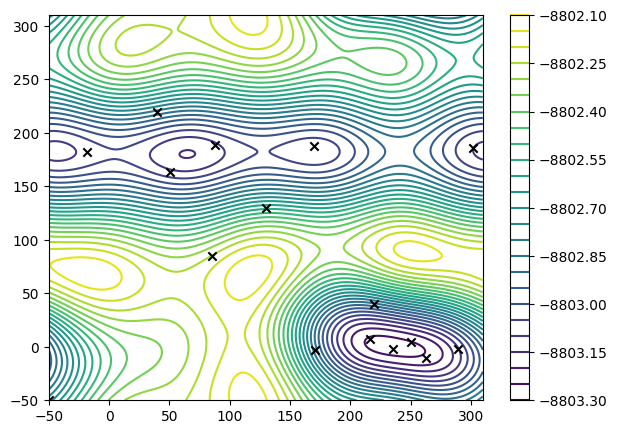

In [40]:
plt.figure(figsize=(7, 5))
yp = bo_3.model.predict(np.column_stack((x1.ravel(), x2.ravel())), index=0)[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.get_X(index=0)[:, 0], bo_3.model.get_X(index=0)[:, 1], marker='x', color='k', zorder=10);

support task:

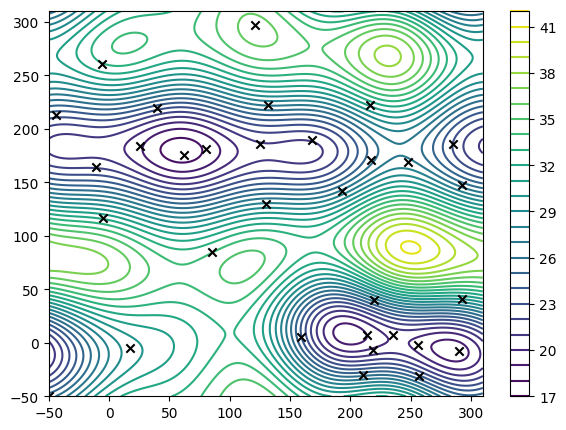

In [41]:
plt.figure(figsize=(7, 5))
yp = bo_3.model.predict(np.column_stack((x1.ravel(), x2.ravel())), index=1)[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.get_X(index=1)[:, 0], bo_3.model.get_X(index=1)[:, 1], marker='x', color='k', zorder=10);

num evaluations:

In [42]:
dict(zip(['E1', 'E0'], np.bincount(bo_3.model.inds)))

{'E1': 16, 'E0': 32}